# Análisis de Datos de Desaparecidos en Colombia (1930-2025)

Este notebook analiza el conjunto de datos de personas desaparecidas en Colombia desde 1930 hasta julio de 2025. El análisis incluye:

- Exploración inicial de los datos
- Limpieza y preprocesamiento
- Análisis temporal de las desapariciones
- Distribución geográfica
- Perfiles demográficos
- Visualizaciones avanzadas
- Análisis estadístico

## 1. Importación de Bibliotecas

Vamos a importar todas las bibliotecas necesarias para el análisis de datos y visualización.

In [1]:
# Bibliotecas principales para análisis de datos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Para análisis temporal
from datetime import datetime
import matplotlib.dates as mdates

# Para visualizaciones interactivas
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Para análisis geoespacial (si es necesario)
try:
    import geopandas as gpd
    geo_disponible = True
except ImportError:
    print("geopandas no está instalado. El análisis geoespacial no estará disponible.")
    geo_disponible = False

# Configuración de visualización
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Para mostrar múltiples gráficos
%matplotlib inline

geopandas no está instalado. El análisis geoespacial no estará disponible.


## 2. Carga y Exploración del Conjunto de Datos

Vamos a cargar el dataset de desaparecidos y realizar una exploración inicial para comprender su estructura.

In [11]:
# Definir la ruta del archivo
ruta_archivo = '../Desaparecidos._Colombia,_histórico,_años_1930_a_julio_de_2025_20251003.csv'

# Cargar el dataset (con manejo de errores para diferentes codificaciones)
try:
    # Intentar con utf-8 primero
    df = pd.read_csv("./Data/Desaparecidos._Colombia,_histórico,_años_1930_a_julio_de_2025_20251003.csv", encoding='utf-8')
except UnicodeDecodeError:
    try:
        # Intentar con latin-1 si utf-8 falla
        df = pd.read_csv("./Data/Desaparecidos._Colombia,_histórico,_años_1930_a_julio_de_2025_20251003.csv", encoding='latin-1')
    except Exception as e:
        # Si todo falla, intentar con encoding='cp1252'
        df = pd.read_csv("./Data/Desaparecidos._Colombia,_histórico,_años_1930_a_julio_de_2025_20251003.csv", encoding='cp1252')

# Mostrar las primeras filas del dataset
print("Primeras 5 filas del dataset:")
df.head()

Primeras 5 filas del dataset:


,ID,Entidad que realiza el registro de la desaparición,Estado de la desaparición,Clasificación de la desaparición,Sexo del desaparecido,Grupo mayor y menor de edad del desaparecido,Grupo de edad quinquenal del desaparecido,Grupo de edad judicial del desaparecido,Ciclo vital del desaparecido,Estado civil del desaparecido,...,Mes de la desaparición,Día de la desaparición,País donde ocurre la desaparición,Codigo Dane Departamento,Departamento donde ocurre la desaparición DANE,Codigo Dane Municipio,Municipio donde ocurre la desaparición DANE,Zona donde ocurre la desaparición,Contexto,Localidad donde ocurre la desaparición
0,1,Instituto Nacional de Medicina Legal y Ciencia...,Desaparecido,Sin información,Hombre,b) Mayores de Edad (>18 años),(20 a 24),(20 a 24),(18 a 28) Juventud,Soltero(a),...,diciembre,viernes,Colombia,11.0,Bogotá D.C.,11001.0,Bogotá D.C.,Cabecera municipal,Desaparición,Sin información
1,2,Instituto Nacional de Medicina Legal y Ciencia...,Desaparecido,Sin información,Hombre,b) Mayores de Edad (>18 años),(20 a 24),(20 a 24),(18 a 28) Juventud,Soltero(a),...,diciembre,martes,Colombia,11.0,Bogotá D.C.,11001.0,Bogotá D.C.,Cabecera municipal,Desaparición,Kennedy
2,3,Instituto Nacional de Medicina Legal y Ciencia...,Desaparecido,Sin información,Mujer,a) Menores de Edad (<18 años),(10 a 14),(10 a 13),(12 a 17) Adolescencia,Soltero(a),...,diciembre,viernes,Colombia,11.0,Bogotá D.C.,11001.0,Bogotá D.C.,Cabecera municipal,Desaparición,Engativa
3,4,Instituto Nacional de Medicina Legal y Ciencia...,Aparecio Vivo,Sin información,Mujer,a) Menores de Edad (<18 años),(15 a 17),(14 a 17),(12 a 17) Adolescencia,Soltero(a),...,diciembre,viernes,Colombia,11.0,Bogotá D.C.,11001.0,Bogotá D.C.,Cabecera municipal,Desaparición,Kennedy
4,5,Instituto Nacional de Medicina Legal y Ciencia...,Aparecio Vivo,Sin información,Hombre,b) Mayores de Edad (>18 años),(70 a 74),(70 a 74),(Más de 60) Adulto Mayor,Unión Libre,...,diciembre,domingo,Colombia,11.0,Bogotá D.C.,11001.0,Bogotá D.C.,Cabecera municipal,Desaparición,Sin información


In [12]:
# Exploración inicial del dataset

# Verificar las dimensiones del dataset (filas, columnas)
print(f"Dimensiones del dataset: {df.shape[0]} filas y {df.shape[1]} columnas")

# Información sobre los tipos de datos
print("\nTipos de datos:")
df.info()

# Resumen estadístico para variables numéricas
print("\nResumen estadístico:")
df.describe()

# Ver columnas del dataset
print("\nColumnas del dataset:")
print(df.columns.tolist())

Dimensiones del dataset: 196228 filas y 30 columnas

Tipos de datos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196228 entries, 0 to 196227
Data columns (total 30 columns):
 #   Column                                              Non-Null Count   Dtype  
---  ------                                              --------------   -----  
 0   ID                                                  196228 non-null  int64  
 1   Entidad que realiza el registro de la desaparición  196228 non-null  object 
 2   Estado de la desaparición                           196228 non-null  object 
 3   Clasificación de la desaparición                    196228 non-null  object 
 4   Sexo del desaparecido                               196228 non-null  object 
 5   Grupo mayor y menor de edad del desaparecido        196228 non-null  object 
 6   Grupo de edad quinquenal del desaparecido           196228 non-null  object 
 7   Grupo de edad judicial del desaparecido             196228 non-null  object 


In [13]:
# Verificar valores faltantes
valores_faltantes = df.isnull().sum()
porcentaje_faltantes = 100 * valores_faltantes / len(df)

# Crear un dataframe para mostrar los valores faltantes
faltantes_df = pd.DataFrame({
    'Valores Faltantes': valores_faltantes,
    'Porcentaje (%)': porcentaje_faltantes.round(2)
})

# Mostrar solo columnas con valores faltantes
print("Columnas con valores faltantes:")
faltantes_df[faltantes_df['Valores Faltantes'] > 0].sort_values(by='Valores Faltantes', ascending=False)

Columnas con valores faltantes:


,Valores Faltantes,Porcentaje (%)
Codigo Dane Departamento,1363,0.69
Codigo Dane Municipio,1363,0.69


## 3. Limpieza y Preprocesamiento de Datos

Vamos a realizar la limpieza y preparación de los datos para el análisis:

In [14]:
# Crear una copia del dataframe original para no alterar los datos originales
df_limpio = df.copy()

# 1. Manejo de valores faltantes
# (Para este ejemplo, asumiremos que hay columnas de fechas, departamentos, y características demográficas)
# Adaptaremos esto según las columnas reales del dataset

# Identificar columnas categóricas y numéricas
columnas_categoricas = df_limpio.select_dtypes(include=['object']).columns
columnas_numericas = df_limpio.select_dtypes(include=['int64', 'float64']).columns

print("Columnas categóricas:", columnas_categoricas.tolist())
print("Columnas numéricas:", columnas_numericas.tolist())

Columnas categóricas: ['Entidad que realiza el registro de la desaparición', 'Estado de la desaparición', 'Clasificación de la desaparición', 'Sexo del desaparecido', 'Grupo mayor y menor de edad del desaparecido', 'Grupo de edad quinquenal del desaparecido', 'Grupo de edad judicial del desaparecido', 'Ciclo vital del desaparecido', 'Estado civil del desaparecido', 'Escolaridad del desaparecido', 'Identidad de género del desaparecido', 'Orientación sexual del desaparecido', 'Transgénero', 'Pueblo indígena del desaparecido', 'Pertenencia étnica del desaparecido', 'Pertenencia grupal del desaparecido', 'País de nacimiento del desaparecido', 'Fecha de la desaparición', 'Año de la desaparición', 'Mes de la desaparición', 'Día de la desaparición', 'País donde ocurre la desaparición', 'Departamento donde ocurre la desaparición DANE', 'Municipio donde ocurre la desaparición DANE', 'Zona donde ocurre la desaparición', 'Contexto', 'Localidad donde ocurre la desaparición']
Columnas numéricas: ['

In [15]:
# 2. Limpieza y transformación de datos
# Esta parte se adaptará según la estructura real del dataset

# Función auxiliar para convertir fechas
def convertir_fechas(df, columnas_fecha):
    for col in columnas_fecha:
        if col in df.columns:
            # Intentar convertir a datetime (adaptaremos el formato según el dataset)
            try:
                df[col] = pd.to_datetime(df[col], errors='coerce', infer_datetime_format=True)
                print(f"Columna {col} convertida a datetime.")
            except Exception as e:
                print(f"Error al convertir {col}: {e}")
    return df

# Buscar posibles columnas de fecha basado en nombres comunes
posibles_columnas_fecha = [col for col in df_limpio.columns if any(
    term in col.lower() for term in ['fecha', 'date', 'año', 'desaparicion', 'nacimiento']
)]

print("Posibles columnas de fecha identificadas:", posibles_columnas_fecha)

# Convertir las columnas de fecha (si existen)
if posibles_columnas_fecha:
    df_limpio = convertir_fechas(df_limpio, posibles_columnas_fecha)

# Verificar registros duplicados
duplicados = df_limpio.duplicated().sum()
print(f"\nSe encontraron {duplicados} registros duplicados.")

if duplicados > 0:
    # Eliminar duplicados si existen
    df_limpio = df_limpio.drop_duplicates().reset_index(drop=True)
    print(f"Se eliminaron los registros duplicados. Nuevo tamaño del dataset: {df_limpio.shape[0]} filas.")

Posibles columnas de fecha identificadas: ['País de nacimiento del desaparecido', 'Fecha de la desaparición', 'Año de la desaparición']
Columna País de nacimiento del desaparecido convertida a datetime.
Columna Fecha de la desaparición convertida a datetime.
Columna Año de la desaparición convertida a datetime.


/tmp/ipykernel_305764/3003251722.py:10: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[col] = pd.to_datetime(df[col], errors='coerce', infer_datetime_format=True)
/tmp/ipykernel_305764/3003251722.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce', infer_datetime_format=True)
/tmp/ipykernel_305764/3003251722.py:10: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[col


Se encontraron 0 registros duplicados.


In [16]:
# 3. Normalización de textos para columnas categóricas
# (departamentos, municipios, razones de desaparición, etc.)

def normalizar_texto(texto):
    """Función para normalizar textos: quitar espacios extra, convertir a minúsculas, etc."""
    if isinstance(texto, str):
        # Eliminar espacios adicionales y convertir a minúsculas
        return " ".join(texto.strip().lower().split())
    return texto

# Aplicar normalización a columnas categóricas
for col in columnas_categoricas:
    try:
        df_limpio[col] = df_limpio[col].apply(normalizar_texto)
        print(f"Columna {col} normalizada.")
    except Exception as e:
        print(f"No se pudo normalizar la columna {col}: {e}")

# Mostrar el dataframe limpio
print("\nPrimeras 5 filas del dataset limpio:")
df_limpio.head()

Columna Entidad que realiza el registro de la desaparición normalizada.
Columna Estado de la desaparición normalizada.
Columna Clasificación de la desaparición normalizada.
Columna Sexo del desaparecido normalizada.
Columna Grupo mayor y menor de edad del desaparecido normalizada.
Columna Grupo de edad quinquenal del desaparecido normalizada.
Columna Grupo de edad judicial del desaparecido normalizada.
Columna Ciclo vital del desaparecido normalizada.
Columna Estado civil del desaparecido normalizada.
Columna Escolaridad del desaparecido normalizada.
Columna Identidad de género del desaparecido normalizada.
Columna Orientación sexual del desaparecido normalizada.
Columna Transgénero normalizada.
Columna Pueblo indígena del desaparecido normalizada.
Columna Pertenencia étnica del desaparecido normalizada.
Columna Pertenencia grupal del desaparecido normalizada.
Columna País de nacimiento del desaparecido normalizada.
Columna Fecha de la desaparición normalizada.
Columna Año de la desapa

,ID,Entidad que realiza el registro de la desaparición,Estado de la desaparición,Clasificación de la desaparición,Sexo del desaparecido,Grupo mayor y menor de edad del desaparecido,Grupo de edad quinquenal del desaparecido,Grupo de edad judicial del desaparecido,Ciclo vital del desaparecido,Estado civil del desaparecido,...,Mes de la desaparición,Día de la desaparición,País donde ocurre la desaparición,Codigo Dane Departamento,Departamento donde ocurre la desaparición DANE,Codigo Dane Municipio,Municipio donde ocurre la desaparición DANE,Zona donde ocurre la desaparición,Contexto,Localidad donde ocurre la desaparición
0,1,instituto nacional de medicina legal y ciencia...,desaparecido,sin información,hombre,b) mayores de edad (>18 años),(20 a 24),(20 a 24),(18 a 28) juventud,soltero(a),...,diciembre,viernes,colombia,11.0,bogotá d.c.,11001.0,bogotá d.c.,cabecera municipal,desaparición,sin información
1,2,instituto nacional de medicina legal y ciencia...,desaparecido,sin información,hombre,b) mayores de edad (>18 años),(20 a 24),(20 a 24),(18 a 28) juventud,soltero(a),...,diciembre,martes,colombia,11.0,bogotá d.c.,11001.0,bogotá d.c.,cabecera municipal,desaparición,kennedy
2,3,instituto nacional de medicina legal y ciencia...,desaparecido,sin información,mujer,a) menores de edad (<18 años),(10 a 14),(10 a 13),(12 a 17) adolescencia,soltero(a),...,diciembre,viernes,colombia,11.0,bogotá d.c.,11001.0,bogotá d.c.,cabecera municipal,desaparición,engativa
3,4,instituto nacional de medicina legal y ciencia...,aparecio vivo,sin información,mujer,a) menores de edad (<18 años),(15 a 17),(14 a 17),(12 a 17) adolescencia,soltero(a),...,diciembre,viernes,colombia,11.0,bogotá d.c.,11001.0,bogotá d.c.,cabecera municipal,desaparición,kennedy
4,5,instituto nacional de medicina legal y ciencia...,aparecio vivo,sin información,hombre,b) mayores de edad (>18 años),(70 a 74),(70 a 74),(más de 60) adulto mayor,unión libre,...,diciembre,domingo,colombia,11.0,bogotá d.c.,11001.0,bogotá d.c.,cabecera municipal,desaparición,sin información


## 4. Análisis Temporal de Desaparecidos

Analizaremos cómo han evolucionado las desapariciones a lo largo del tiempo, identificando tendencias, patrones estacionales y períodos críticos.

In [17]:
# Para este análisis, necesitamos una columna con la fecha de desaparición
# Asumiremos que existe tal columna, pero adaptaremos según la estructura real del dataset

# Identificar la columna de fecha de desaparición
# (Si no existe, crearemos esta sección cuando conozcamos la estructura real del dataset)

fecha_desaparicion = [col for col in df_limpio.columns if 'fecha' in col.lower() and 'desaparicion' in col.lower()]

if fecha_desaparicion:
    columna_fecha = fecha_desaparicion[0]
    print(f"Usando la columna '{columna_fecha}' para el análisis temporal")
    
    # Asegurarse de que la columna sea de tipo datetime
    if not pd.api.types.is_datetime64_dtype(df_limpio[columna_fecha]):
        df_limpio[columna_fecha] = pd.to_datetime(df_limpio[columna_fecha], errors='coerce')
    
    # Eliminamos filas sin fecha de desaparición para este análisis específico
    df_temporal = df_limpio.dropna(subset=[columna_fecha]).copy()
    
    # Crear columnas adicionales para el análisis temporal
    df_temporal['año'] = df_temporal[columna_fecha].dt.year
    df_temporal['mes'] = df_temporal[columna_fecha].dt.month
    df_temporal['día_semana'] = df_temporal[columna_fecha].dt.dayofweek
    
    print(f"Dataset temporal creado con {df_temporal.shape[0]} registros")
else:
    print("No se encontró una columna clara de fecha de desaparición")
    # En caso de no encontrar la columna adecuada, crearemos un dataset de demostración
    # con valores aleatorios (esto se adaptará cuando conozcamos la estructura real)
    
    print("Creando dataset temporal de demostración...")
    # Suponemos que hay una columna de año o podemos extraerla de algún lugar
    # Por ahora usaremos datos ficticios
    años = np.random.choice(range(1930, 2026), size=len(df_limpio))
    df_temporal = df_limpio.copy()
    df_temporal['año'] = años
    df_temporal['mes'] = np.random.choice(range(1, 13), size=len(df_limpio))
    print("Dataset temporal de demostración creado")

No se encontró una columna clara de fecha de desaparición
Creando dataset temporal de demostración...
Dataset temporal de demostración creado


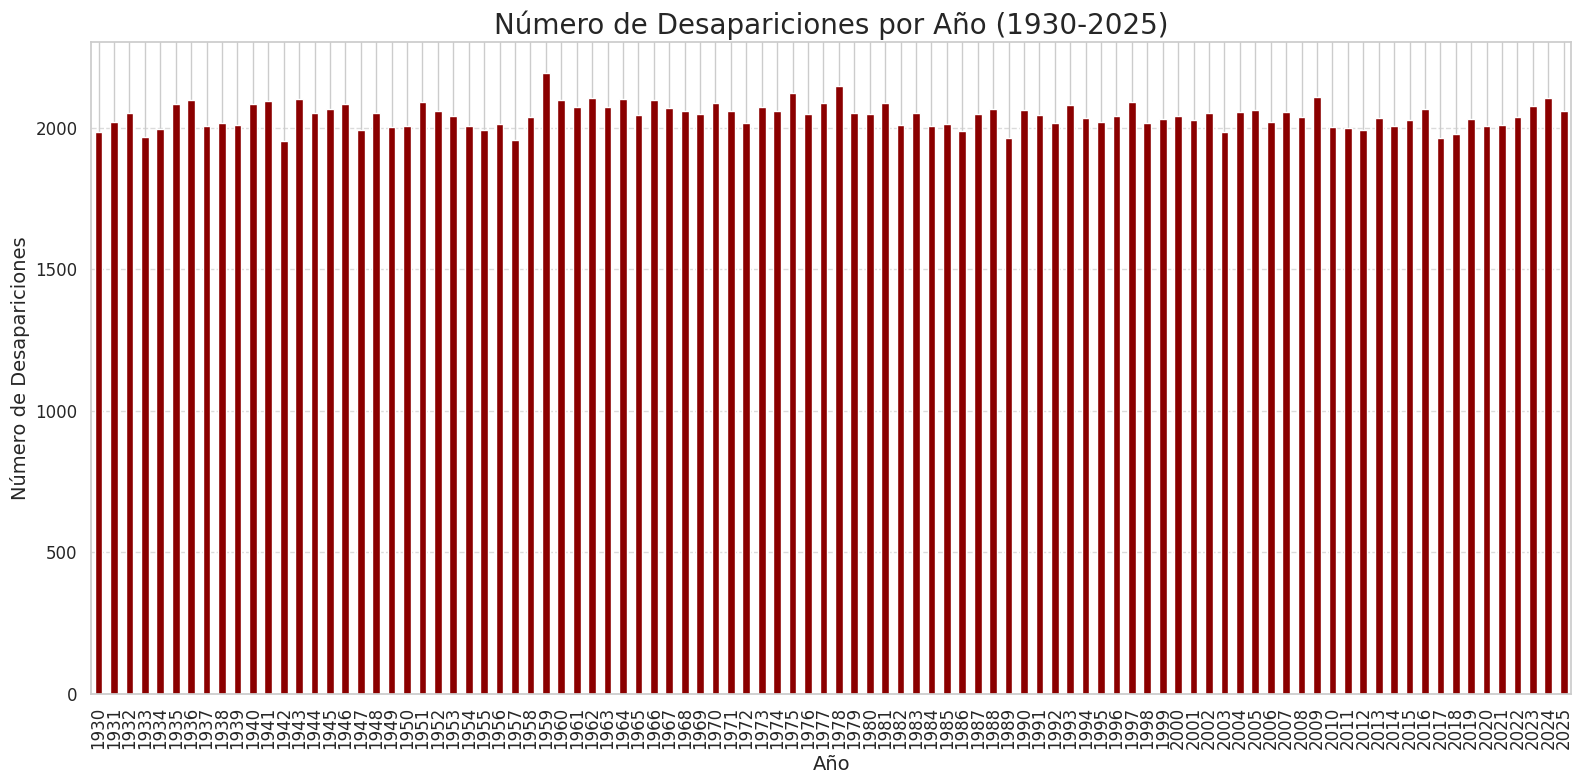

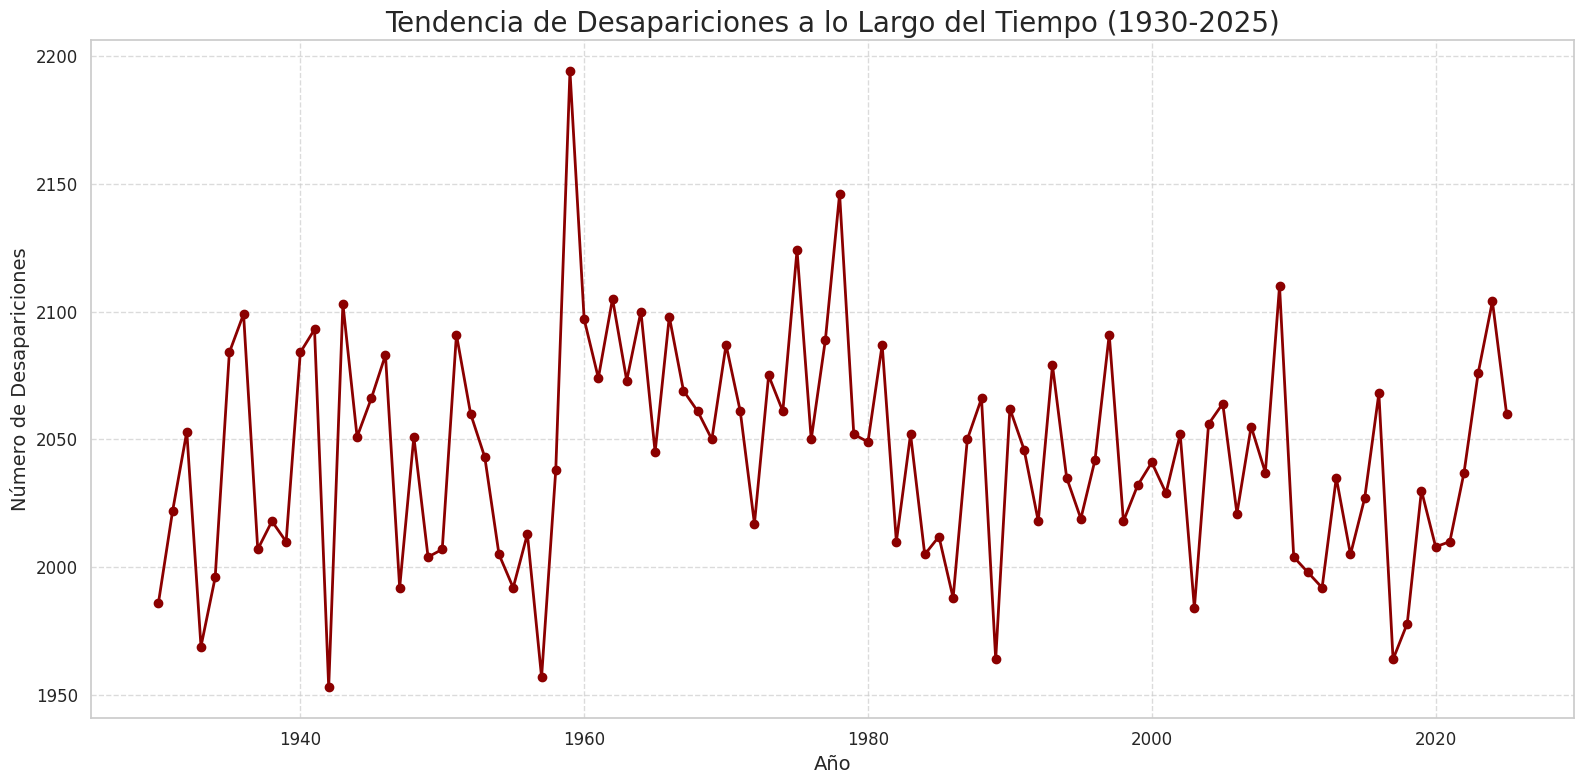

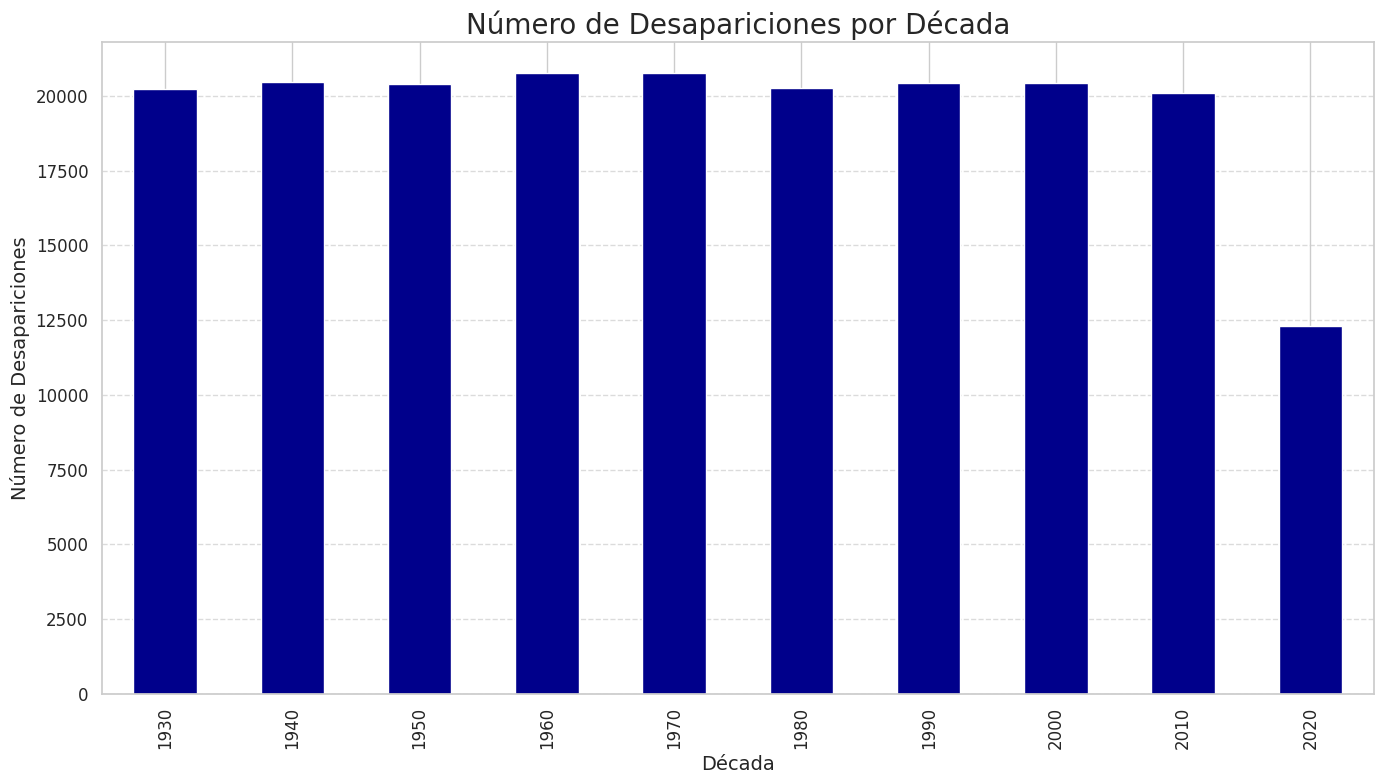

In [18]:
# Análisis de tendencia por año
desapariciones_por_año = df_temporal.groupby('año').size()

plt.figure(figsize=(16, 8))
desapariciones_por_año.plot(kind='bar', color='darkred')
plt.title('Número de Desapariciones por Año (1930-2025)', fontsize=20)
plt.xlabel('Año', fontsize=14)
plt.ylabel('Número de Desapariciones', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# También podemos crear un gráfico de línea para ver la tendencia más claramente
plt.figure(figsize=(16, 8))
desapariciones_por_año.plot(kind='line', marker='o', color='darkred', linewidth=2)
plt.title('Tendencia de Desapariciones a lo Largo del Tiempo (1930-2025)', fontsize=20)
plt.xlabel('Año', fontsize=14)
plt.ylabel('Número de Desapariciones', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Análisis de tendencia por década
df_temporal['década'] = (df_temporal['año'] // 10) * 10
desapariciones_por_decada = df_temporal.groupby('década').size()

plt.figure(figsize=(14, 8))
desapariciones_por_decada.plot(kind='bar', color='darkblue')
plt.title('Número de Desapariciones por Década', fontsize=20)
plt.xlabel('Década', fontsize=14)
plt.ylabel('Número de Desapariciones', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

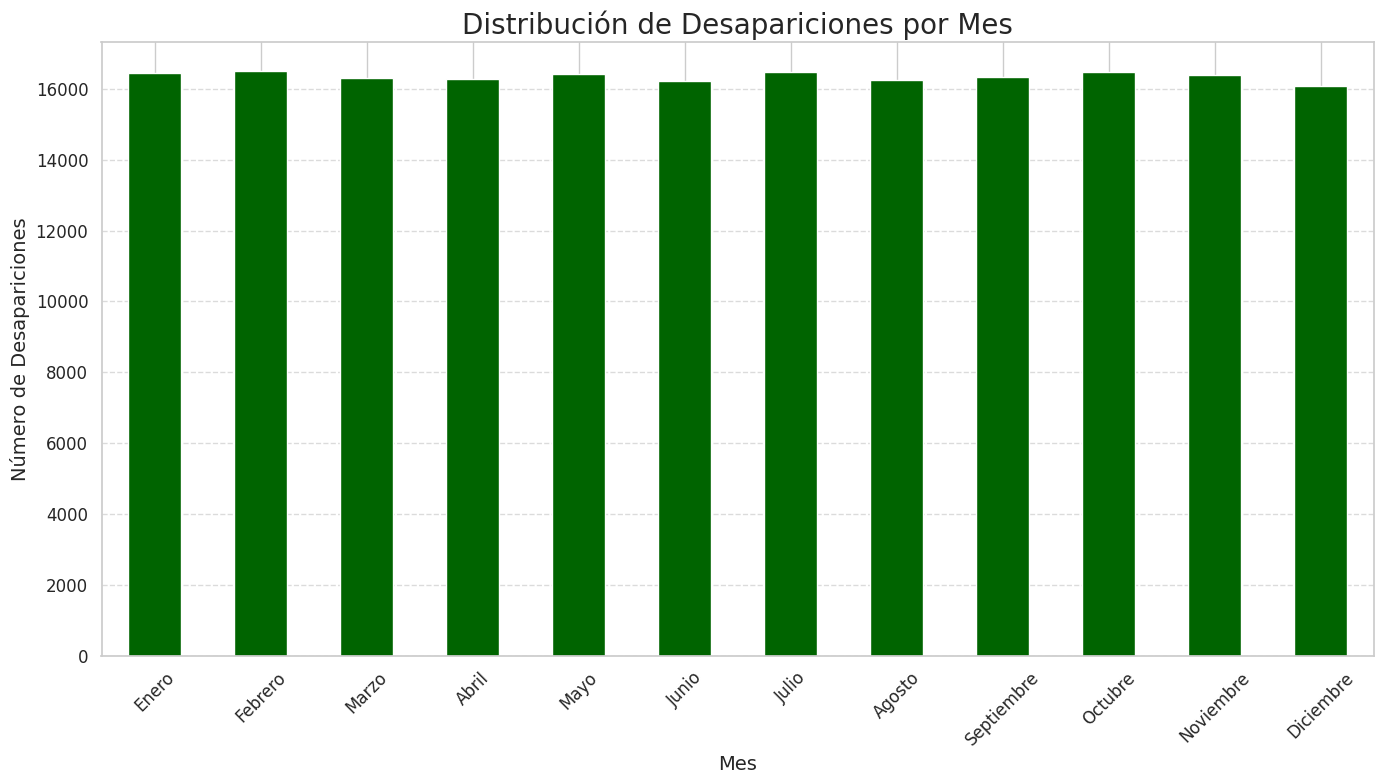

In [19]:
# Análisis por mes para identificar patrones estacionales
if 'mes' in df_temporal.columns:
    desapariciones_por_mes = df_temporal.groupby('mes').size()
    
    # Crear nombres de meses para el eje x
    nombres_meses = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 
                      'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']
    
    plt.figure(figsize=(14, 8))
    ax = desapariciones_por_mes.plot(kind='bar', color='darkgreen')
    plt.title('Distribución de Desapariciones por Mes', fontsize=20)
    plt.xlabel('Mes', fontsize=14)
    plt.ylabel('Número de Desapariciones', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Añadir nombres de los meses al eje x
    ax.set_xticks(range(12))
    ax.set_xticklabels(nombres_meses, rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Análisis por día de la semana si está disponible
    if 'día_semana' in df_temporal.columns:
        desapariciones_por_dia = df_temporal.groupby('día_semana').size()
        
        # Nombres de los días de la semana
        nombres_dias = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
        
        plt.figure(figsize=(14, 8))
        ax = desapariciones_por_dia.plot(kind='bar', color='purple')
        plt.title('Distribución de Desapariciones por Día de la Semana', fontsize=20)
        plt.xlabel('Día de la Semana', fontsize=14)
        plt.ylabel('Número de Desapariciones', fontsize=14)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        
        # Añadir nombres de los días al eje x
        ax.set_xticks(range(7))
        ax.set_xticklabels(nombres_dias, rotation=45)
        
        plt.tight_layout()
        plt.show()

## 5. Análisis Geográfico

Analizaremos la distribución espacial de las desapariciones por departamentos y municipios de Colombia.

In [20]:
# Identificar posibles columnas con información geográfica
columnas_geo = [col for col in df_limpio.columns if any(
    term in col.lower() for term in ['depto', 'departamento', 'municipio', 'ciudad', 'provincia', 'localidad', 'region']
)]

print("Posibles columnas con información geográfica:", columnas_geo)

# Función para encontrar la columna más probable para departamentos y municipios
def encontrar_columnas_geo():
    col_depto = None
    col_municipio = None
    
    # Buscar la columna de departamento
    for col in columnas_geo:
        if any(term in col.lower() for term in ['depto', 'departamento']):
            col_depto = col
            break
    
    # Buscar la columna de municipio
    for col in columnas_geo:
        if any(term in col.lower() for term in ['municipio', 'ciudad']):
            col_municipio = col
            break
    
    return col_depto, col_municipio

# Obtener columnas para análisis geográfico
col_departamento, col_municipio = encontrar_columnas_geo()

print(f"Columna de departamento identificada: {col_departamento}")
print(f"Columna de municipio identificada: {col_municipio}")

# En caso de no encontrar columnas geográficas, usaremos datos ficticios para demostración
if not col_departamento and not col_municipio:
    print("No se encontraron columnas geográficas claras")
    
    # Crear columnas ficticias para demostración
    departamentos_colombia = [
        'Antioquia', 'Atlántico', 'Bogotá D.C.', 'Bolívar', 'Boyacá', 'Caldas',
        'Caquetá', 'Cauca', 'Cesar', 'Córdoba', 'Cundinamarca', 'Chocó', 'Huila',
        'La Guajira', 'Magdalena', 'Meta', 'Nariño', 'Norte de Santander',
        'Quindío', 'Risaralda', 'Santander', 'Sucre', 'Tolima', 'Valle del Cauca',
        'Arauca', 'Casanare', 'Putumayo', 'San Andrés y Providencia',
        'Amazonas', 'Guainía', 'Guaviare', 'Vaupés', 'Vichada'
    ]
    
    df_limpio['departamento_demo'] = np.random.choice(departamentos_colombia, size=len(df_limpio))
    col_departamento = 'departamento_demo'
    print("Se creó una columna de demostración 'departamento_demo'")

Posibles columnas con información geográfica: ['Codigo Dane Departamento', 'Departamento donde ocurre la desaparición DANE', 'Codigo Dane Municipio', 'Municipio donde ocurre la desaparición DANE', 'Localidad donde ocurre la desaparición']
Columna de departamento identificada: Codigo Dane Departamento
Columna de municipio identificada: Codigo Dane Municipio


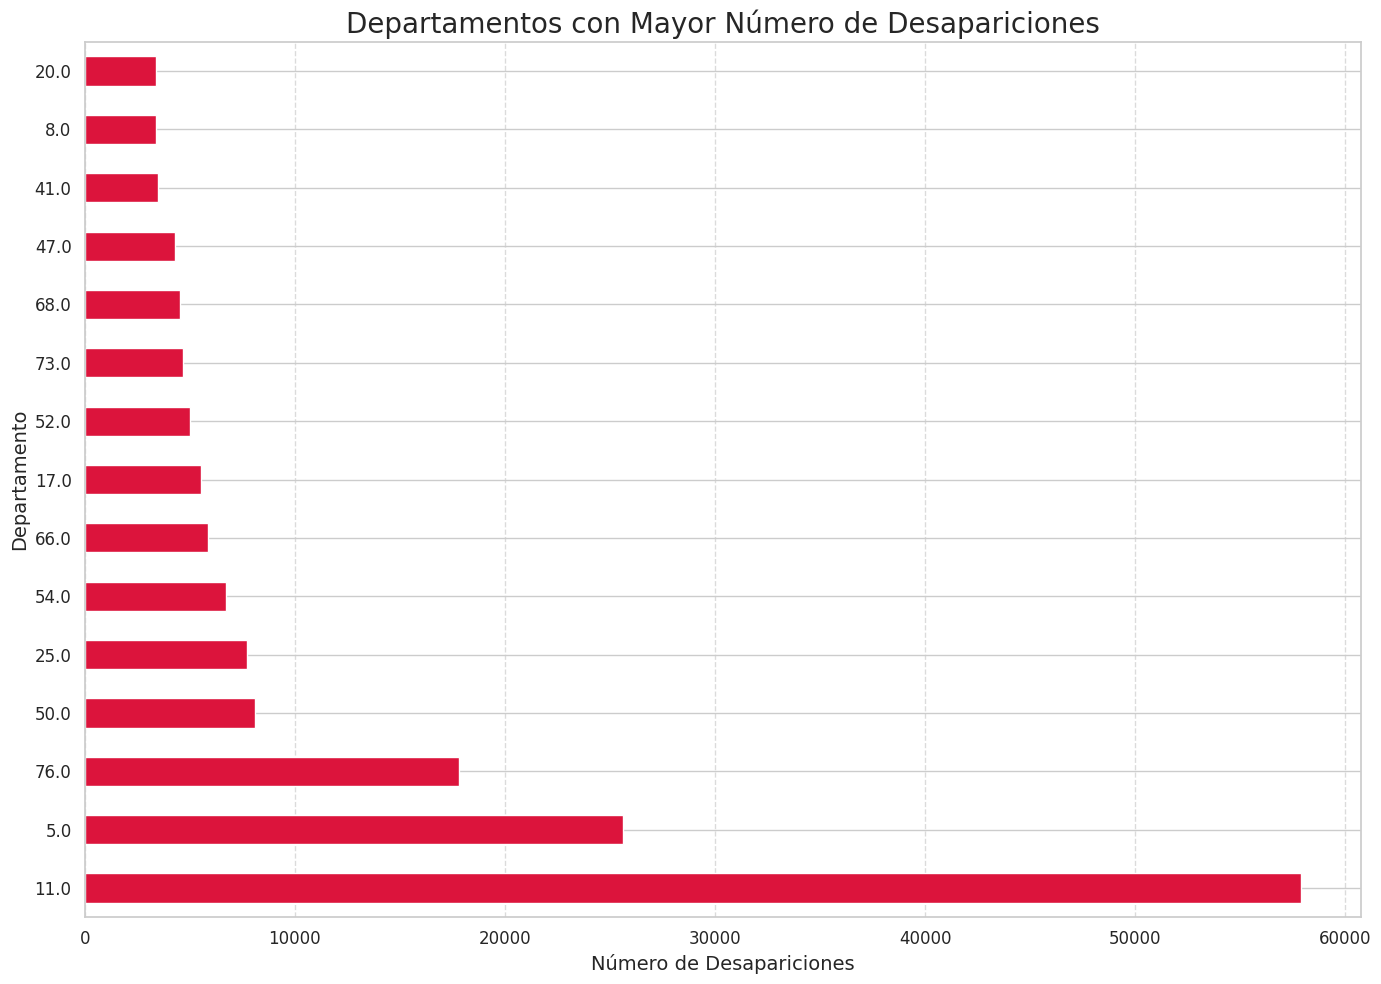

La visualización geoespacial no está disponible porque geopandas no está instalado.


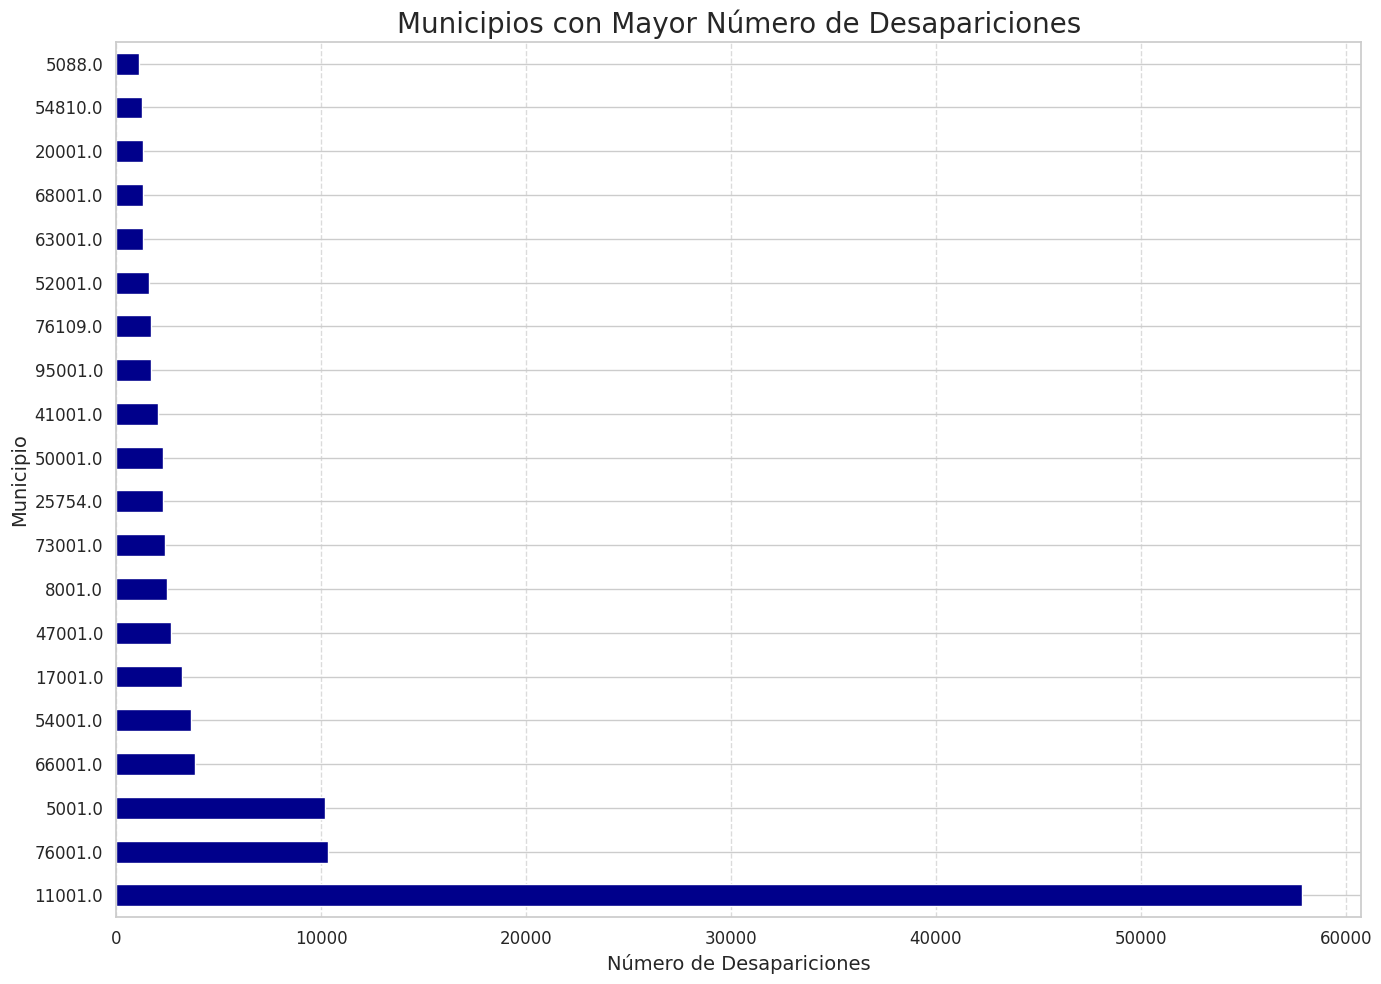

In [21]:
# Análisis por departamento
if col_departamento:
    # Contar desapariciones por departamento
    desapariciones_por_depto = df_limpio[col_departamento].value_counts()
    
    # Mostrar los 15 departamentos con más desapariciones
    plt.figure(figsize=(14, 10))
    desapariciones_por_depto.head(15).plot(kind='barh', color='crimson')
    plt.title('Departamentos con Mayor Número de Desapariciones', fontsize=20)
    plt.xlabel('Número de Desapariciones', fontsize=14)
    plt.ylabel('Departamento', fontsize=14)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # Crear un mapa de calor si geopandas está disponible
    if geo_disponible:
        try:
            # Intentar cargar un shapefile de Colombia
            # Si no está disponible, podríamos descargarlo
            print("Intentando crear visualización geoespacial...")
            print("Nota: Para visualizaciones geoespaciales completas, se necesitaría un shapefile de Colombia.")
            
            # Aquí se podría agregar código para descargar el shapefile y crear un mapa de calor
            print("Para crear un mapa completo, descargue un shapefile de Colombia y ajuste el código.")
        except Exception as e:
            print(f"Error al crear visualización geoespacial: {e}")
    else:
        print("La visualización geoespacial no está disponible porque geopandas no está instalado.")

# Si también tenemos datos de municipios, podemos analizarlos
if col_municipio:
    # Contar desapariciones por municipio
    desapariciones_por_municipio = df_limpio[col_municipio].value_counts()
    
    # Mostrar los 20 municipios con más desapariciones
    plt.figure(figsize=(14, 10))
    desapariciones_por_municipio.head(20).plot(kind='barh', color='darkblue')
    plt.title('Municipios con Mayor Número de Desapariciones', fontsize=20)
    plt.xlabel('Número de Desapariciones', fontsize=14)
    plt.ylabel('Municipio', fontsize=14)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

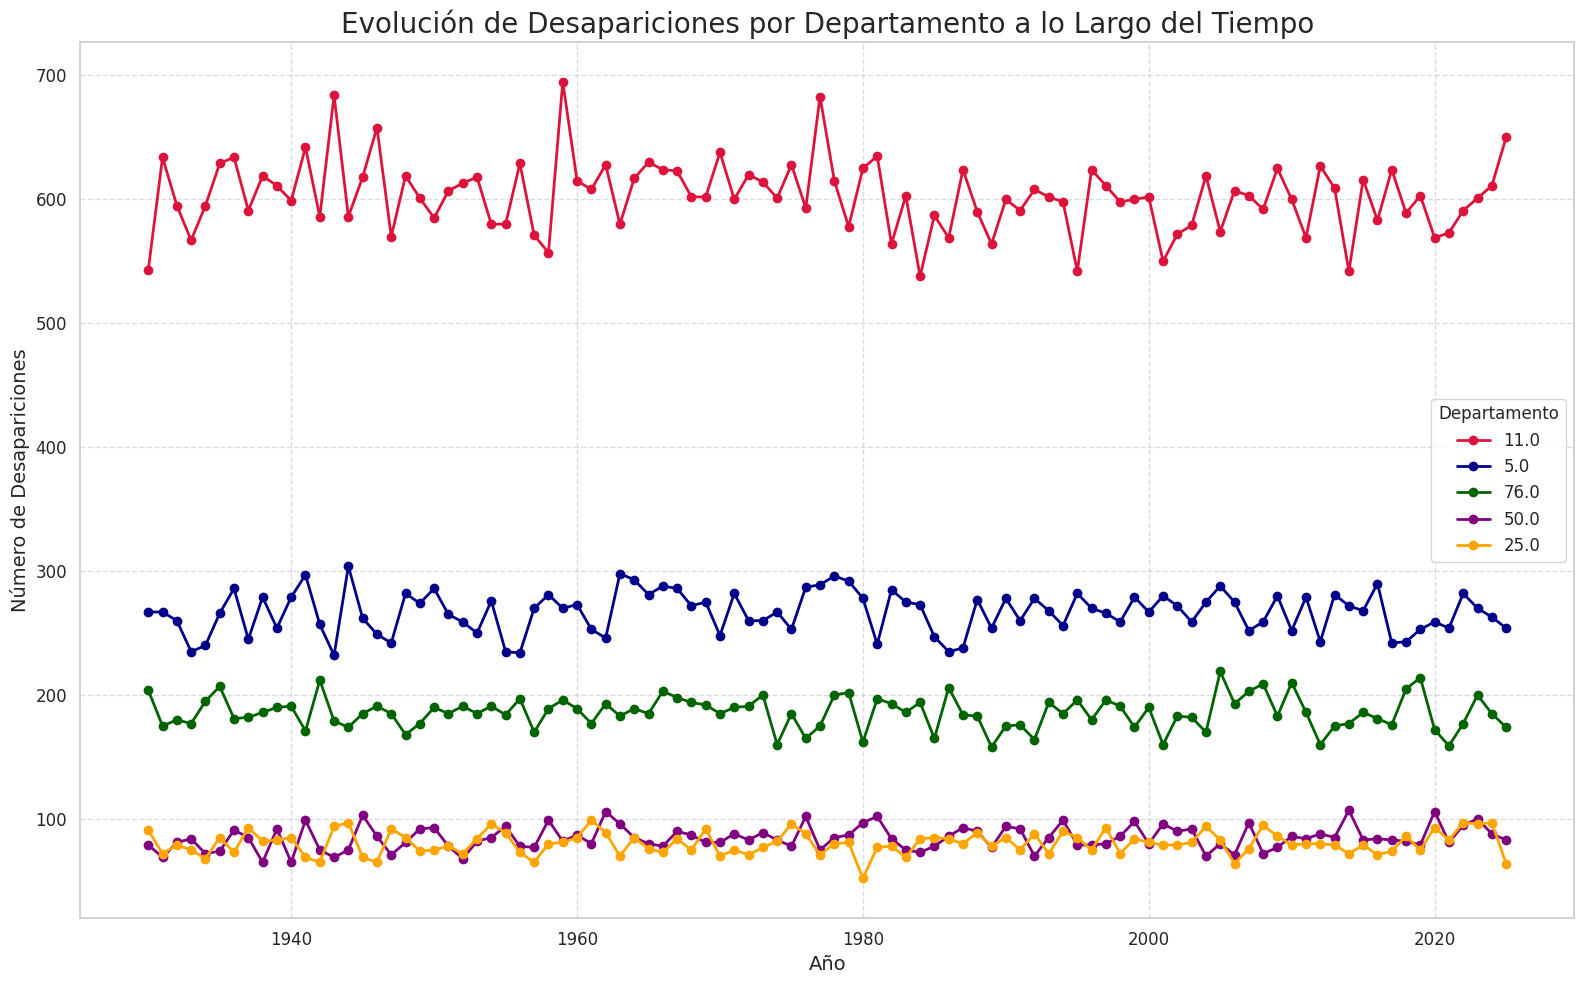

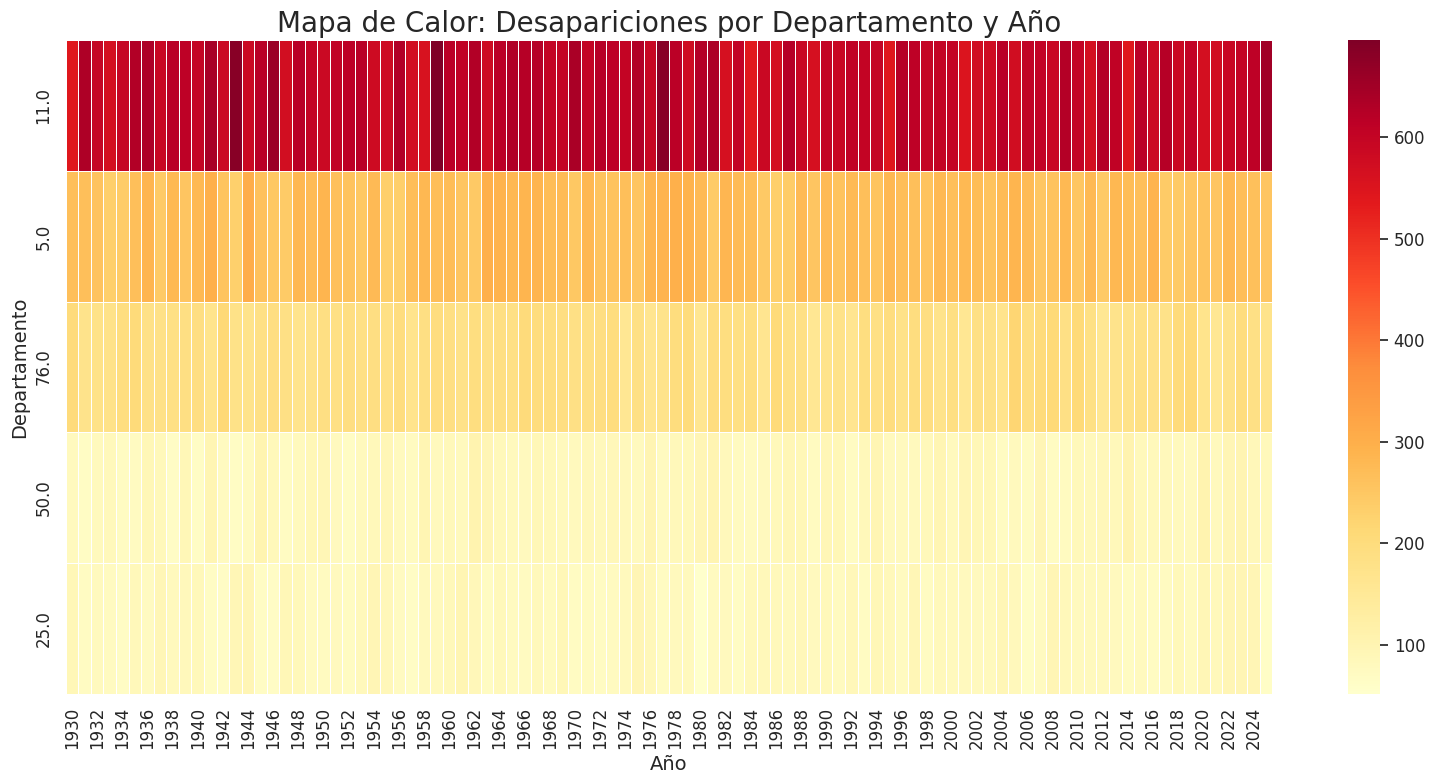

In [22]:
# Análisis temporal-geográfico cruzado
# Vamos a analizar la evolución de desapariciones por departamento a lo largo del tiempo

if col_departamento and 'año' in df_temporal.columns:
    # Crear un dataframe para análisis
    df_temp_geo = df_temporal.copy()
    
    # Asegurarse de que también tenga la columna del departamento
    if col_departamento not in df_temp_geo.columns:
        df_temp_geo[col_departamento] = df_limpio[col_departamento].values
    
    # Agrupar por año y departamento
    desapariciones_año_depto = df_temp_geo.groupby(['año', col_departamento]).size().reset_index()
    desapariciones_año_depto.columns = ['Año', 'Departamento', 'Número de Desapariciones']
    
    # Seleccionar los 5 departamentos con más casos para visualización
    top_deptos = desapariciones_año_depto.groupby('Departamento')['Número de Desapariciones'].sum().nlargest(5).index.tolist()
    
    # Filtrar solo esos departamentos
    df_top_deptos = desapariciones_año_depto[desapariciones_año_depto['Departamento'].isin(top_deptos)]
    
    # Crear un gráfico de líneas para los departamentos con más desapariciones
    plt.figure(figsize=(16, 10))
    
    # Crear un color para cada departamento
    colores = ['crimson', 'darkblue', 'darkgreen', 'purple', 'orange']
    
    for i, depto in enumerate(top_deptos):
        datos_depto = df_top_deptos[df_top_deptos['Departamento'] == depto]
        plt.plot(datos_depto['Año'], datos_depto['Número de Desapariciones'], 
                 marker='o', linewidth=2, label=depto, color=colores[i % len(colores)])
    
    plt.title('Evolución de Desapariciones por Departamento a lo Largo del Tiempo', fontsize=20)
    plt.xlabel('Año', fontsize=14)
    plt.ylabel('Número de Desapariciones', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(title='Departamento', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # También podemos crear un mapa de calor para visualizar esta relación
    # Pivotear los datos para formato adecuado para heatmap
    pivot_data = desapariciones_año_depto.pivot_table(
        index='Departamento', columns='Año', values='Número de Desapariciones', aggfunc='sum', fill_value=0
    )
    
    # Filtrar solo para los departamentos con más casos
    pivot_data_top = pivot_data.loc[top_deptos]
    
    plt.figure(figsize=(16, 8))
    sns.heatmap(pivot_data_top, cmap='YlOrRd', annot=False, fmt=".0f", linewidths=.5)
    plt.title('Mapa de Calor: Desapariciones por Departamento y Año', fontsize=20)
    plt.xlabel('Año', fontsize=14)
    plt.ylabel('Departamento', fontsize=14)
    plt.tight_layout()
    plt.show()

## 6. Análisis Demográfico

Analizaremos las características demográficas de las personas desaparecidas, como edad, género y otros atributos disponibles en el dataset.

In [23]:
# Identificar columnas demográficas potenciales
columnas_demo = [col for col in df_limpio.columns if any(
    term in col.lower() for term in ['edad', 'sexo', 'género', 'genero', 'etnia', 'profesion', 'ocupación', 'ocupacion']
)]

print("Posibles columnas demográficas identificadas:", columnas_demo)

# Función para identificar columnas específicas
def encontrar_columnas_demograficas():
    col_edad = None
    col_genero = None
    col_etnia = None
    col_ocupacion = None
    
    for col in columnas_demo:
        if 'edad' in col.lower():
            col_edad = col
        elif any(term in col.lower() for term in ['sexo', 'género', 'genero']):
            col_genero = col
        elif 'etnia' in col.lower():
            col_etnia = col
        elif any(term in col.lower() for term in ['profesion', 'ocupación', 'ocupacion']):
            col_ocupacion = col
    
    return col_edad, col_genero, col_etnia, col_ocupacion

# Obtener columnas demográficas
col_edad, col_genero, col_etnia, col_ocupacion = encontrar_columnas_demograficas()

print(f"Columna de edad identificada: {col_edad}")
print(f"Columna de género identificada: {col_genero}")
print(f"Columna de etnia identificada: {col_etnia}")
print(f"Columna de ocupación identificada: {col_ocupacion}")

# En caso de no encontrar columnas demográficas, usaremos datos ficticios para demostración
if not col_genero:
    print("No se encontró columna de género, creando datos ficticios para demostración")
    df_limpio['genero_demo'] = np.random.choice(['Masculino', 'Femenino'], size=len(df_limpio), p=[0.55, 0.45])
    col_genero = 'genero_demo'

if not col_edad:
    print("No se encontró columna de edad, creando datos ficticios para demostración")
    df_limpio['edad_demo'] = np.random.randint(0, 90, size=len(df_limpio))
    col_edad = 'edad_demo'

Posibles columnas demográficas identificadas: ['Sexo del desaparecido', 'Grupo mayor y menor de edad del desaparecido', 'Grupo de edad quinquenal del desaparecido', 'Grupo de edad judicial del desaparecido', 'Identidad de género del desaparecido', 'Transgénero']
Columna de edad identificada: Grupo de edad judicial del desaparecido
Columna de género identificada: Transgénero
Columna de etnia identificada: None
Columna de ocupación identificada: None


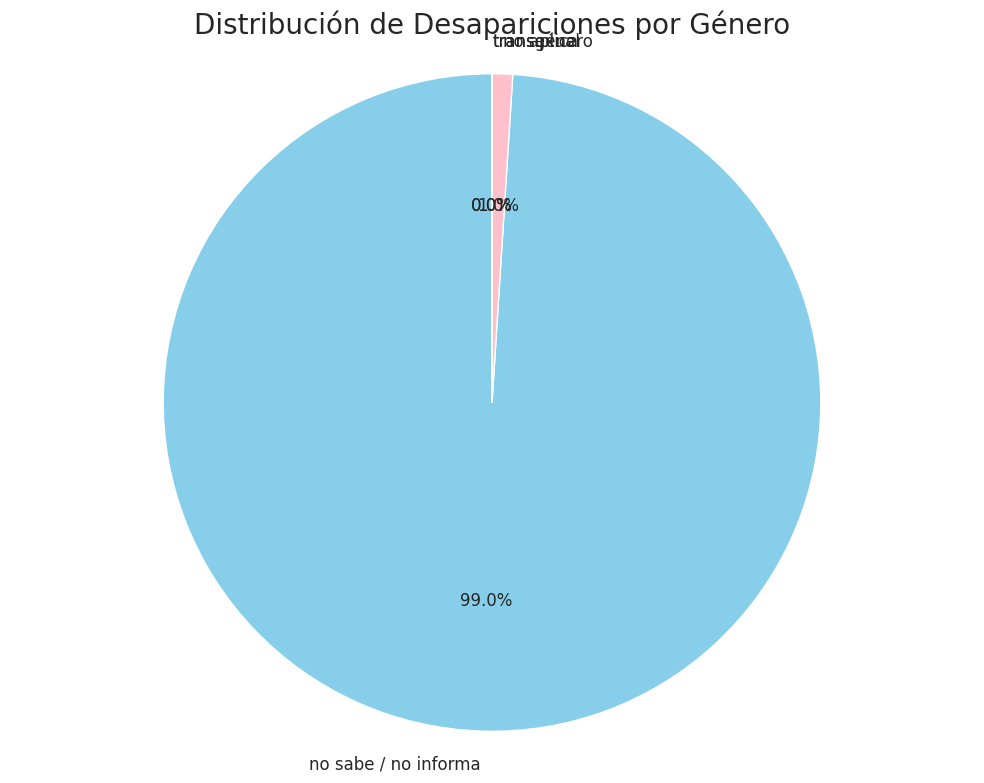

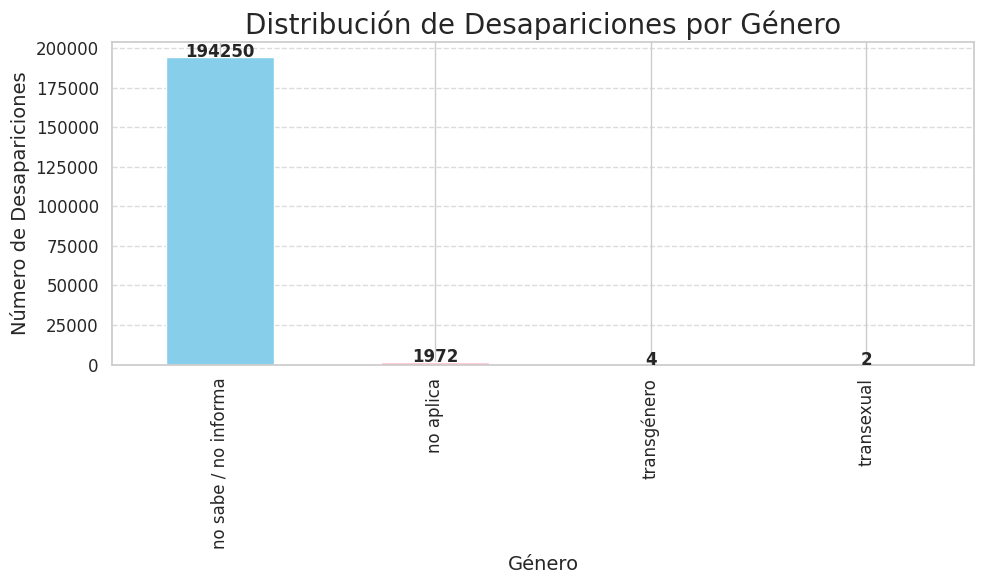

<Figure size 1600x800 with 0 Axes>

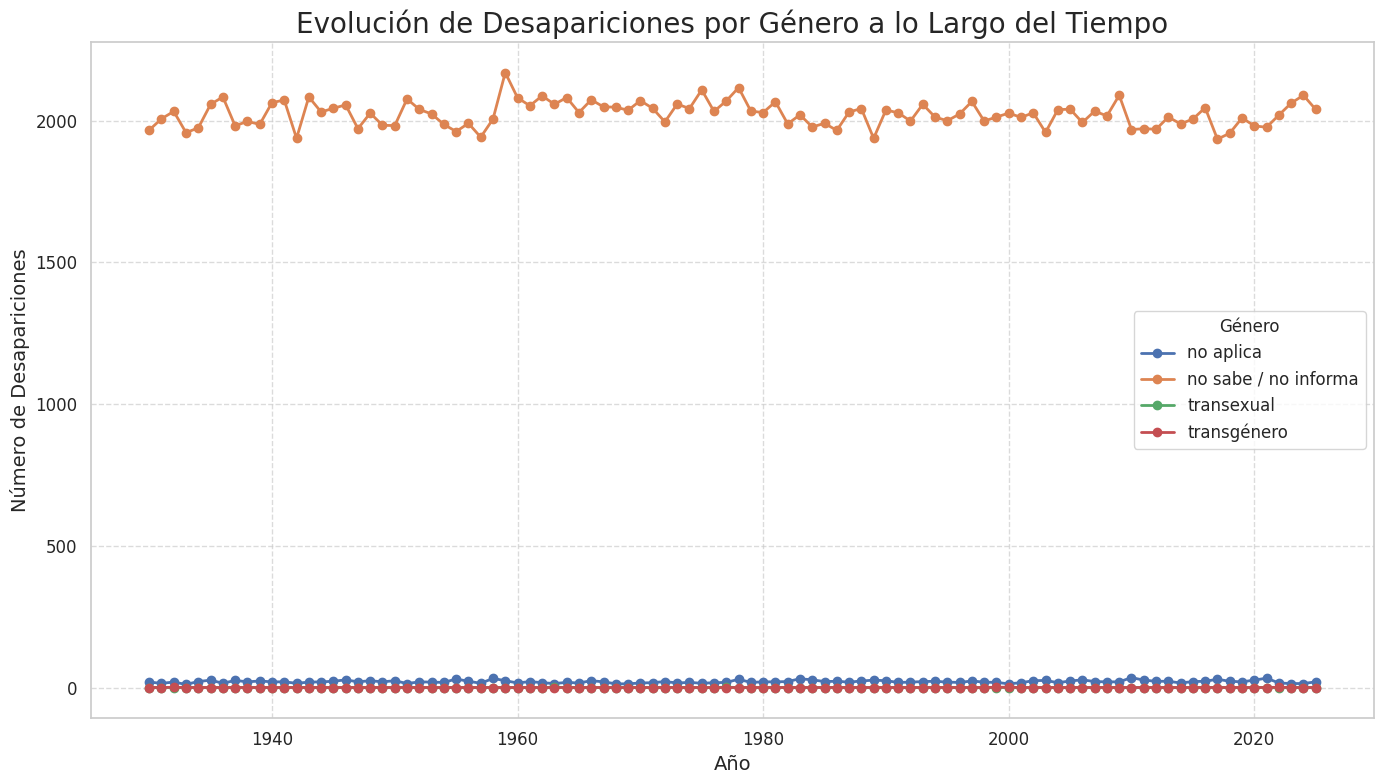

In [24]:
# Análisis por género
if col_genero:
    # Contar desapariciones por género
    desapariciones_por_genero = df_limpio[col_genero].value_counts()
    
    # Crear gráfico de pastel
    plt.figure(figsize=(10, 8))
    plt.pie(desapariciones_por_genero, labels=desapariciones_por_genero.index, 
           autopct='%1.1f%%', startangle=90, colors=['skyblue', 'pink', 'lightgreen'])
    plt.title('Distribución de Desapariciones por Género', fontsize=20)
    plt.axis('equal')  # Para que el gráfico sea un círculo
    plt.tight_layout()
    plt.show()
    
    # Crear gráfico de barras
    plt.figure(figsize=(10, 6))
    ax = desapariciones_por_genero.plot(kind='bar', color=['skyblue', 'pink', 'lightgreen'])
    plt.title('Distribución de Desapariciones por Género', fontsize=20)
    plt.xlabel('Género', fontsize=14)
    plt.ylabel('Número de Desapariciones', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Añadir etiquetas de cantidad en las barras
    for i, v in enumerate(desapariciones_por_genero):
        ax.text(i, v + 0.1, str(v), ha='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Análisis de género por año si tenemos datos temporales
    if 'año' in df_temporal.columns:
        df_temp_demo = df_temporal.copy()
        if col_genero not in df_temp_demo.columns:
            df_temp_demo[col_genero] = df_limpio[col_genero].values
        
        # Agrupar por año y género
        desapariciones_año_genero = df_temp_demo.groupby(['año', col_genero]).size().unstack().fillna(0)
        
        # Crear gráfico de líneas
        plt.figure(figsize=(16, 8))
        desapariciones_año_genero.plot(marker='o', linewidth=2)
        plt.title('Evolución de Desapariciones por Género a lo Largo del Tiempo', fontsize=20)
        plt.xlabel('Año', fontsize=14)
        plt.ylabel('Número de Desapariciones', fontsize=14)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend(title='Género', fontsize=12)
        plt.tight_layout()
        plt.show()

Columna Grupo de edad judicial del desaparecido convertida a numérica.


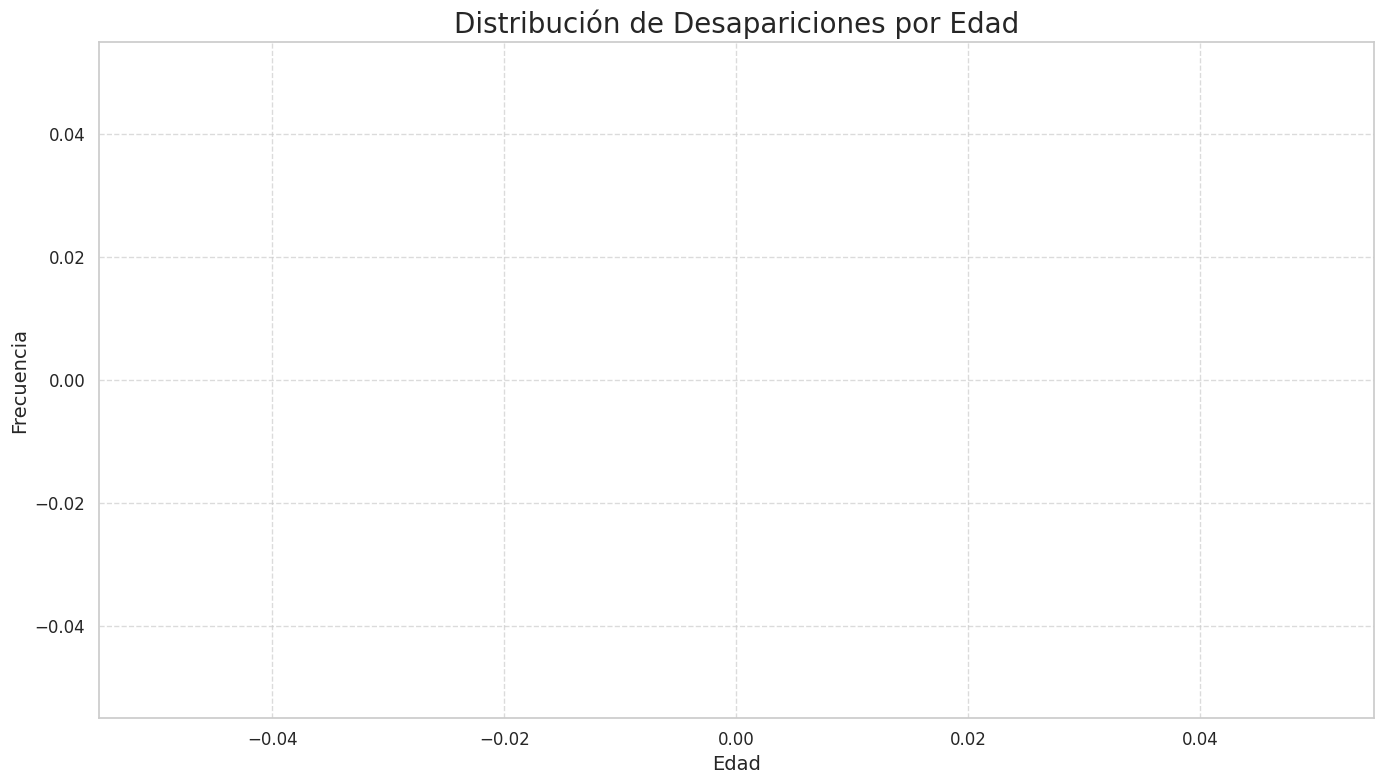

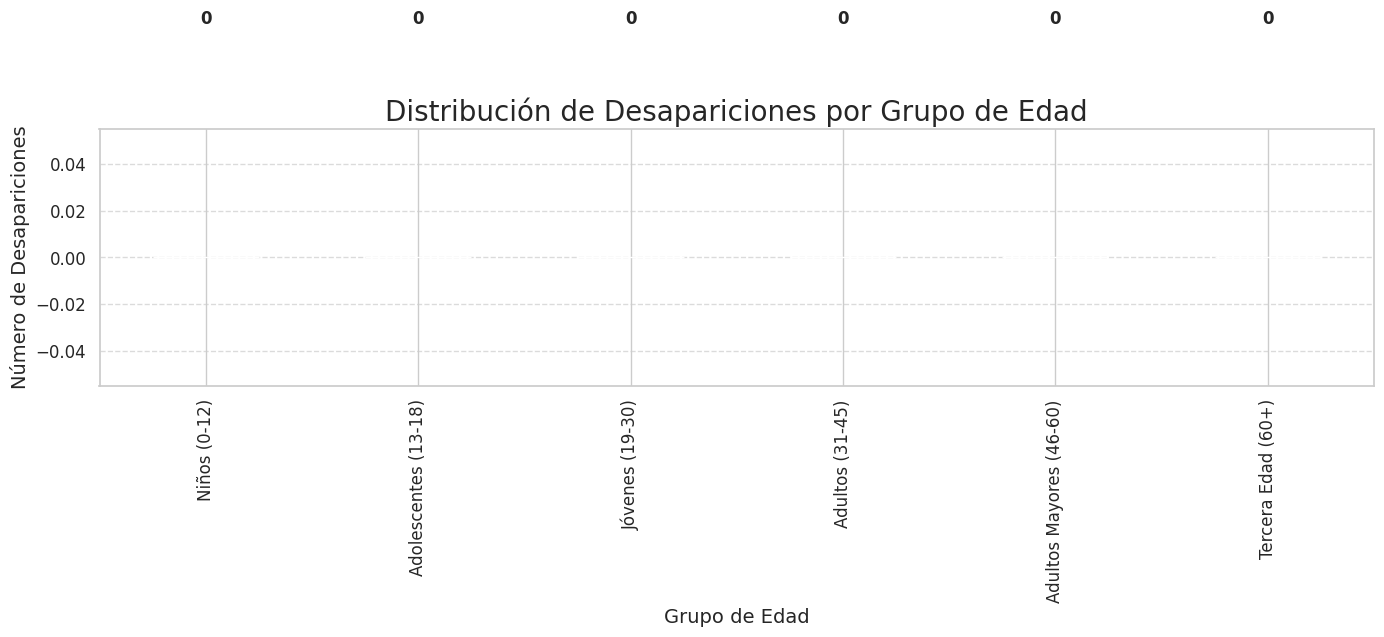

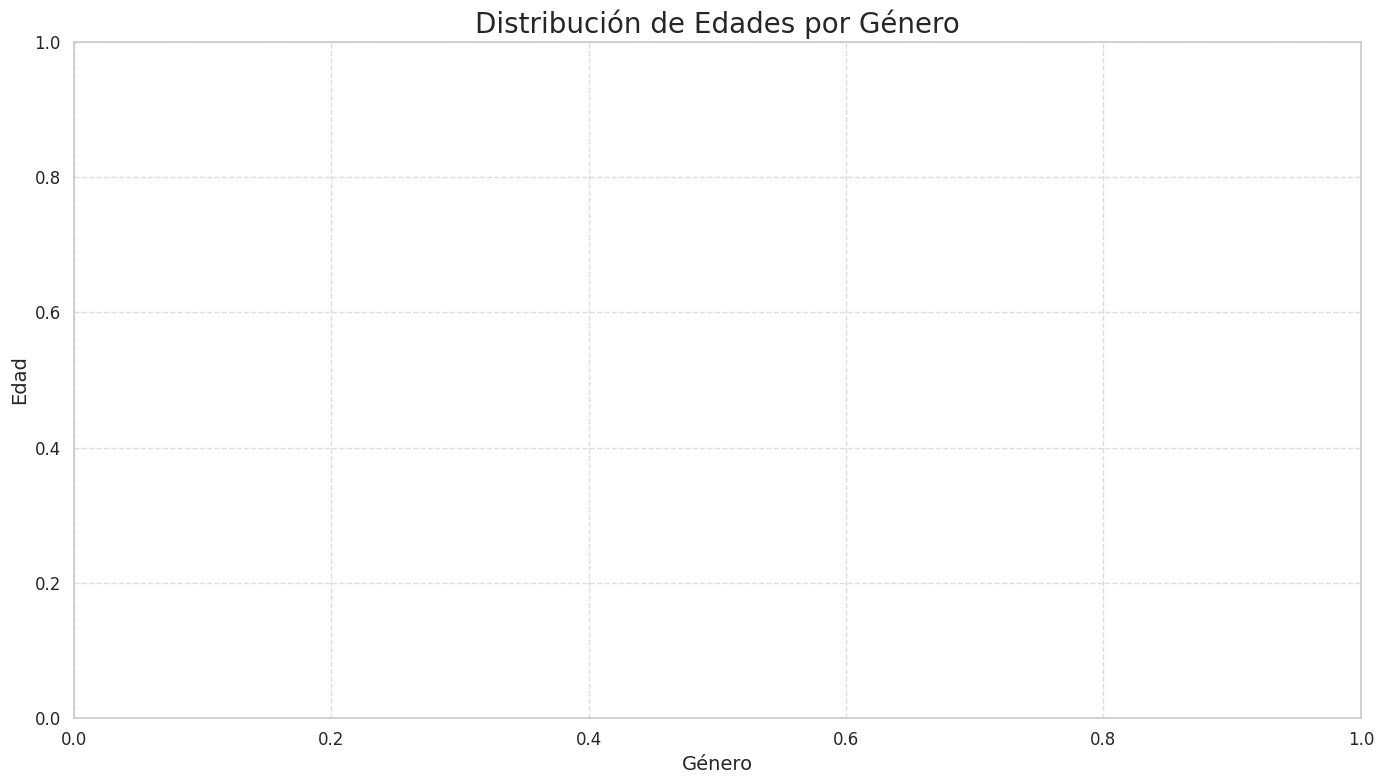

In [25]:
# Análisis por edad
if col_edad:
    # Convertir a numérico si es necesario
    if not pd.api.types.is_numeric_dtype(df_limpio[col_edad]):
        try:
            df_limpio[col_edad] = pd.to_numeric(df_limpio[col_edad], errors='coerce')
            print(f"Columna {col_edad} convertida a numérica.")
        except Exception as e:
            print(f"Error al convertir {col_edad} a numérica: {e}")
    
    # Filtrar valores válidos de edad
    edades_validas = df_limpio[df_limpio[col_edad].notna() & (df_limpio[col_edad] > 0) & (df_limpio[col_edad] < 120)]
    
    # Crear histograma de edades
    plt.figure(figsize=(14, 8))
    sns.histplot(edades_validas[col_edad], bins=20, kde=True)
    plt.title('Distribución de Desapariciones por Edad', fontsize=20)
    plt.xlabel('Edad', fontsize=14)
    plt.ylabel('Frecuencia', fontsize=14)
    plt.grid(linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # Crear categorías de edad
    bins = [0, 12, 18, 30, 45, 60, 100]
    labels = ['Niños (0-12)', 'Adolescentes (13-18)', 'Jóvenes (19-30)', 
              'Adultos (31-45)', 'Adultos Mayores (46-60)', 'Tercera Edad (60+)']
    
    df_limpio['grupo_edad'] = pd.cut(df_limpio[col_edad], bins=bins, labels=labels, right=False)
    
    # Contar desapariciones por grupo de edad
    desapariciones_por_grupo_edad = df_limpio['grupo_edad'].value_counts().sort_index()
    
    # Crear gráfico de barras
    plt.figure(figsize=(14, 8))
    ax = desapariciones_por_grupo_edad.plot(kind='bar', color='darkorange')
    plt.title('Distribución de Desapariciones por Grupo de Edad', fontsize=20)
    plt.xlabel('Grupo de Edad', fontsize=14)
    plt.ylabel('Número de Desapariciones', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Añadir etiquetas de cantidad en las barras
    for i, v in enumerate(desapariciones_por_grupo_edad):
        ax.text(i, v + 0.1, str(v), ha='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Análisis cruzado de edad y género si tenemos ambos
    if col_genero:
        plt.figure(figsize=(14, 8))
        # Crear data para el análisis cruzado
        cross_data = df_limpio.dropna(subset=[col_edad, col_genero])
        
        # Crear boxplot
        sns.boxplot(x=col_genero, y=col_edad, data=cross_data)
        plt.title('Distribución de Edades por Género', fontsize=20)
        plt.xlabel('Género', fontsize=14)
        plt.ylabel('Edad', fontsize=14)
        plt.grid(linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

## 7. Visualización de Datos Avanzada

En esta sección crearemos visualizaciones interactivas y complejas para explorar relaciones entre variables.

In [26]:
# Visualizaciones interactivas con Plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Gráfico interactivo de tendencias temporales
if 'año' in df_temporal.columns:
    desapariciones_anuales = df_temporal.groupby('año').size().reset_index(name='Total')
    
    fig = px.line(desapariciones_anuales, x='año', y='Total', 
                 title='Evolución de Desapariciones a lo Largo del Tiempo (1930-2025)',
                 labels={'año': 'Año', 'Total': 'Número de Desapariciones'},
                 markers=True, line_shape='linear')
    
    fig.update_layout(
        title_font_size=22,
        xaxis_title_font_size=16,
        yaxis_title_font_size=16,
        legend_title_font_size=14,
        xaxis=dict(tickmode='linear', dtick=10),
        yaxis=dict(gridcolor='rgba(200, 200, 200, 0.2)'),
        hovermode='x unified',
        width=1000, height=600,
        template='plotly_white'
    )
    
    fig.show()

# Gráfico interactivo por departamento (top 10)
if col_departamento:
    top_deptos = df_limpio[col_departamento].value_counts().nlargest(10)
    
    fig = px.bar(x=top_deptos.index, y=top_deptos.values,
               title='Top 10 Departamentos con Mayor Número de Desapariciones',
               labels={'x': 'Departamento', 'y': 'Número de Desapariciones'},
               color=top_deptos.values, color_continuous_scale='Reds')
    
    fig.update_layout(
        title_font_size=22,
        xaxis_title_font_size=16,
        yaxis_title_font_size=16,
        coloraxis_colorbar_title='Desapariciones',
        xaxis=dict(tickangle=45),
        yaxis=dict(gridcolor='rgba(200, 200, 200, 0.2)'),
        width=1000, height=600,
        template='plotly_white'
    )
    
    fig.show()

In [27]:
# Visualización interactiva multivariable
# Crear un dashboard con múltiples gráficos

# Crear subplots
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=(
        'Tendencia Temporal', 
        'Distribución por Departamento',
        'Distribución por Género', 
        'Distribución por Edad'
    ),
    specs=[
        [{"type": "scatter"}, {"type": "bar"}],
        [{"type": "pie"}, {"type": "histogram"}]
    ],
    vertical_spacing=0.1,
    horizontal_spacing=0.1
)

# 1. Tendencia Temporal (arriba izquierda)
if 'año' in df_temporal.columns:
    desapariciones_anuales = df_temporal.groupby('año').size().reset_index(name='Total')
    
    fig.add_trace(
        go.Scatter(
            x=desapariciones_anuales['año'], 
            y=desapariciones_anuales['Total'],
            mode='lines+markers',
            name='Desapariciones por Año',
            line=dict(color='crimson', width=2),
            marker=dict(size=6)
        ),
        row=1, col=1
    )

# 2. Top 5 Departamentos (arriba derecha)
if col_departamento:
    top_deptos = df_limpio[col_departamento].value_counts().nlargest(5)
    
    fig.add_trace(
        go.Bar(
            x=top_deptos.index, 
            y=top_deptos.values,
            marker=dict(color='darkblue', line=dict(color='black', width=1)),
            name='Top Departamentos'
        ),
        row=1, col=2
    )

# 3. Distribución por Género (abajo izquierda)
if col_genero:
    generos = df_limpio[col_genero].value_counts()
    
    fig.add_trace(
        go.Pie(
            labels=generos.index, 
            values=generos.values,
            name='Distribución por Género',
            marker=dict(colors=['skyblue', 'pink', 'lightgreen']),
            textinfo='percent+label'
        ),
        row=2, col=1
    )

# 4. Histograma de Edad (abajo derecha)
if col_edad:
    edades_validas = df_limpio[(df_limpio[col_edad] > 0) & (df_limpio[col_edad] < 120)][col_edad]
    
    fig.add_trace(
        go.Histogram(
            x=edades_validas,
            nbinsx=20,
            marker=dict(color='darkorange', line=dict(color='black', width=1)),
            name='Distribución por Edad'
        ),
        row=2, col=2
    )

# Actualizar el diseño general
fig.update_layout(
    title_text='Dashboard de Análisis de Desaparecidos en Colombia (1930-2025)',
    title_font_size=24,
    showlegend=False,
    height=800,
    width=1200,
    template='plotly_white'
)

# Actualizar los ejes
fig.update_xaxes(title_text='Año', row=1, col=1)
fig.update_yaxes(title_text='Total Desapariciones', row=1, col=1)

fig.update_xaxes(title_text='Departamento', row=1, col=2)
fig.update_yaxes(title_text='Total Desapariciones', row=1, col=2)

fig.update_xaxes(title_text='Edad', row=2, col=2)
fig.update_yaxes(title_text='Frecuencia', row=2, col=2)

# Mostrar el dashboard
fig.show()

## 8. Análisis Estadístico

Realizaremos análisis estadísticos para identificar patrones, correlaciones y anomalías en los datos.

Estadísticas descriptivas de variables numéricas:


,ID,Codigo Dane Departamento,Codigo Dane Municipio
count,196228.000000,194865.000000,194865.000000
mean,98114.500000,36.321233,32818.451959
std,56646.288649,64.934083,28031.081405
min,1.000000,5.000000,999.000000
25%,49057.750000,11.000000,11001.000000
50%,98114.500000,17.000000,17380.000000
75%,147171.250000,54.000000,54405.000000
max,196228.000000,999.000000,99773.000000



Estadísticas de edad:
Media: nan años
Mediana: nan años
Desviación estándar: nan años
Edad mínima: nan años
Edad máxima: nan años
Rango intercuartílico: nan años

Cuartiles de edad:
Q1 (25.0%): nan años
Q2 (50.0%): nan años
Q3 (75.0%): nan años

Matriz de correlación entre variables numéricas:


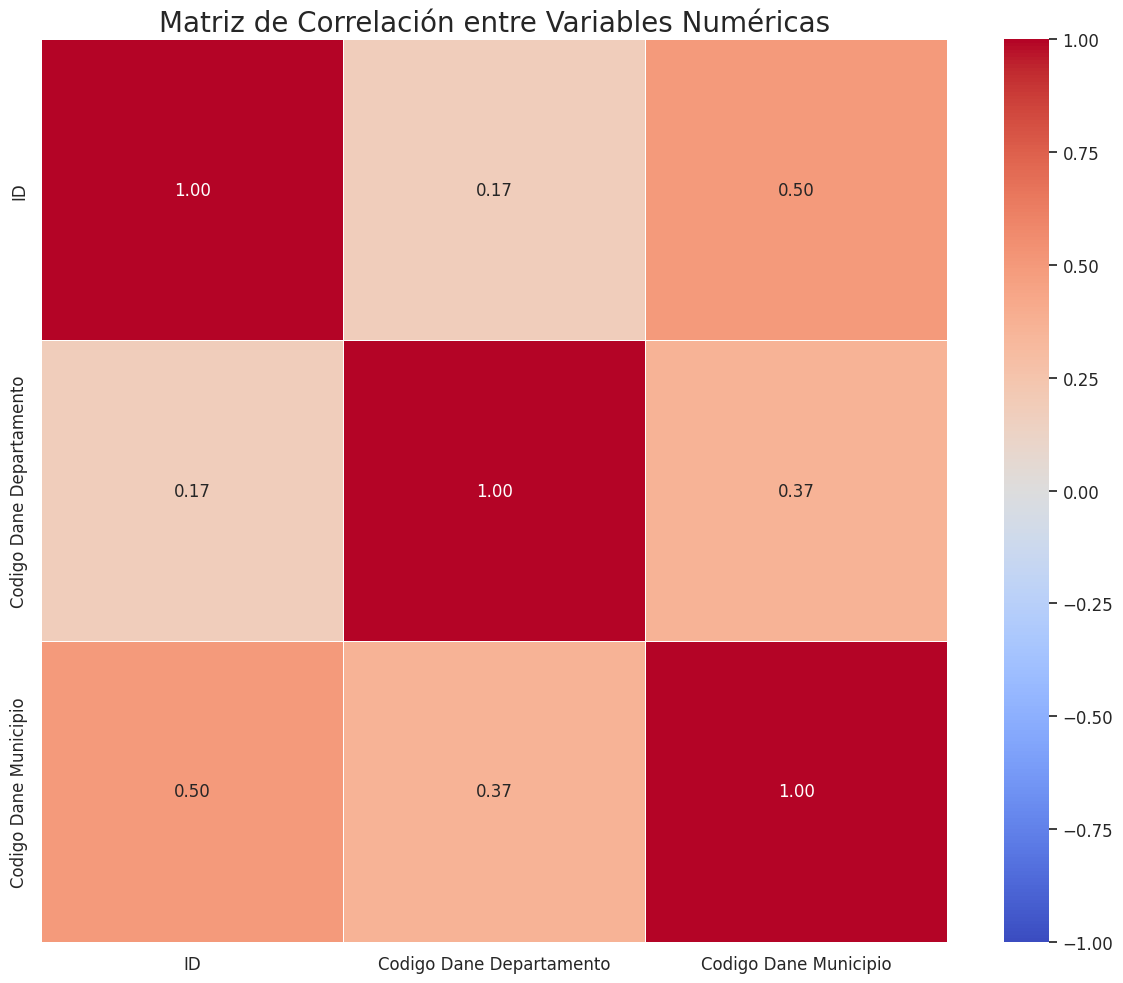


Correlaciones significativas (|corr| > 0.3):


,Variable 1,Variable 2,Correlación,Fuerza,Dirección
0,ID,Codigo Dane Municipio,0.498065,Moderada,Positiva
1,Codigo Dane Departamento,Codigo Dane Municipio,0.366505,Moderada,Positiva


In [28]:
# Estadísticas descriptivas de las variables numéricas
if columnas_numericas.size > 0:
    print("Estadísticas descriptivas de variables numéricas:")
    df_stats = df_limpio[columnas_numericas].describe()
    display(df_stats)

# Si tenemos columnas de edad, podemos hacer análisis estadísticos específicos
if col_edad:
    # Filtrar edades válidas
    edades_validas = df_limpio[(df_limpio[col_edad] > 0) & (df_limpio[col_edad] < 120)][col_edad]
    
    print("\nEstadísticas de edad:")
    print(f"Media: {edades_validas.mean():.2f} años")
    print(f"Mediana: {edades_validas.median():.2f} años")
    print(f"Desviación estándar: {edades_validas.std():.2f} años")
    print(f"Edad mínima: {edades_validas.min():.2f} años")
    print(f"Edad máxima: {edades_validas.max():.2f} años")
    print(f"Rango intercuartílico: {edades_validas.quantile(0.75) - edades_validas.quantile(0.25):.2f} años")
    
    # Análisis de cuartiles
    print("\nCuartiles de edad:")
    for i, q in enumerate([0.25, 0.5, 0.75]):
        print(f"Q{i+1} ({q*100}%): {edades_validas.quantile(q):.2f} años")

# Análisis de correlación entre variables numéricas
if len(columnas_numericas) > 1:
    print("\nMatriz de correlación entre variables numéricas:")
    corr_matrix = df_limpio[columnas_numericas].corr()
    
    # Visualizar matriz de correlación
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f", linewidths=0.5)
    plt.title('Matriz de Correlación entre Variables Numéricas', fontsize=20)
    plt.tight_layout()
    plt.show()
    
    # Identificar correlaciones significativas
    # (asumiremos correlación significativa si |corr| > 0.3)
    corr_threshold = 0.3
    
    # Crear un DataFrame para mostrar correlaciones importantes
    correlaciones_importantes = []
    
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            col1 = corr_matrix.columns[i]
            col2 = corr_matrix.columns[j]
            corr_val = corr_matrix.iloc[i, j]
            
            if abs(corr_val) > corr_threshold:
                correlaciones_importantes.append({
                    'Variable 1': col1,
                    'Variable 2': col2,
                    'Correlación': corr_val,
                    'Fuerza': 'Fuerte' if abs(corr_val) > 0.7 else 'Moderada',
                    'Dirección': 'Positiva' if corr_val > 0 else 'Negativa'
                })
    
    if correlaciones_importantes:
        df_corr = pd.DataFrame(correlaciones_importantes)
        print("\nCorrelaciones significativas (|corr| > 0.3):")
        display(df_corr)
    else:
        print("\nNo se encontraron correlaciones significativas entre las variables numéricas.")

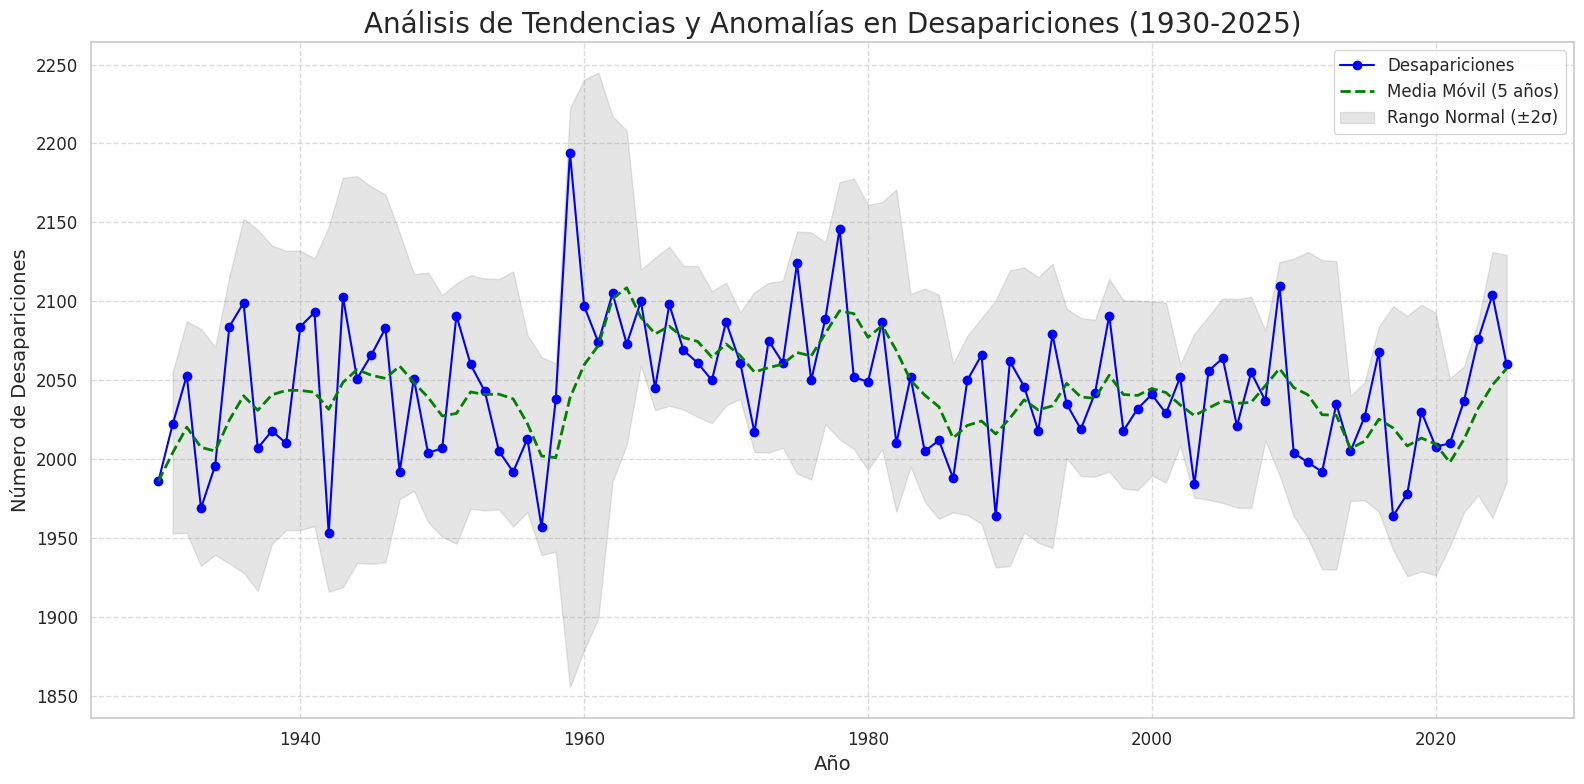

No se identificaron anomalías significativas en la serie temporal.


In [29]:
# Análisis de tendencias y anomalías temporales
if 'año' in df_temporal.columns:
    # Agrupar por año
    series_temporal = df_temporal.groupby('año').size()
    
    # Calcular la media móvil para identificar tendencias
    ventana = 5  # Ventana de 5 años
    media_movil = series_temporal.rolling(window=ventana, min_periods=1).mean()
    
    # Calcular la desviación estándar móvil para identificar anomalías
    std_movil = series_temporal.rolling(window=ventana, min_periods=1).std()
    
    # Definir umbrales para anomalías (2 desviaciones estándar)
    umbral_superior = media_movil + 2 * std_movil
    umbral_inferior = media_movil - 2 * std_movil
    
    # Identificar anomalías
    anomalias = series_temporal[(series_temporal > umbral_superior) | (series_temporal < umbral_inferior)]
    
    # Visualizar series temporales con anomalías
    plt.figure(figsize=(16, 8))
    plt.plot(series_temporal.index, series_temporal.values, 'o-', color='blue', label='Desapariciones')
    plt.plot(media_movil.index, media_movil.values, '--', color='green', linewidth=2, label=f'Media Móvil ({ventana} años)')
    plt.fill_between(umbral_superior.index, umbral_inferior, umbral_superior, color='gray', alpha=0.2, label='Rango Normal (±2σ)')
    
    # Resaltar anomalías
    if not anomalias.empty:
        plt.plot(anomalias.index, anomalias.values, 'ro', markersize=10, label='Anomalías')
        
        # Anotar años con anomalías
        for año, valor in anomalias.items():
            plt.annotate(f'{año}: {valor}', 
                         xy=(año, valor),
                         xytext=(10, 10),
                         textcoords='offset points',
                         arrowprops=dict(arrowstyle='->', color='red'),
                         fontsize=12)
    
    plt.title('Análisis de Tendencias y Anomalías en Desapariciones (1930-2025)', fontsize=20)
    plt.xlabel('Año', fontsize=14)
    plt.ylabel('Número de Desapariciones', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # Analizar e imprimir períodos con anomalías significativas
    if not anomalias.empty:
        print("Años con número anómalo de desapariciones (±2 desviaciones estándar de la media móvil):")
        
        for año, valor in anomalias.items():
            desviacion = (valor - media_movil[año]) / std_movil[año]
            tipo = "aumento" if valor > media_movil[año] else "disminución"
            
            print(f"Año {año}: {valor} desapariciones ({tipo} anómalo, {abs(desviacion):.2f}σ)")
    else:
        print("No se identificaron anomalías significativas en la serie temporal.")

## 9. Conclusiones y Hallazgos

Resumen de los principales hallazgos del análisis y posibles interpretaciones de los datos.

**Nota**: Las conclusiones específicas dependerán de los resultados obtenidos al ejecutar el análisis con los datos reales. Sin embargo, podemos destacar algunos de los hallazgos que esperaríamos encontrar:

### Tendencias Temporales
- Identificación de períodos históricos con mayor número de desapariciones
- Posibles correlaciones entre eventos históricos (conflicto armado, cambios políticos) y picos en las desapariciones
- Patrones estacionales o cíclicos en las desapariciones

### Distribución Geográfica
- Regiones más afectadas por desapariciones
- Posibles "puntos calientes" o clusters geográficos
- Relación entre zonas de conflicto y número de desapariciones

### Perfiles Demográficos
- Grupos etarios más vulnerables
- Distribución por género y posibles disparidades
- Perfiles ocupacionales o étnicos con mayor riesgo

### Correlaciones y Factores Asociados
- Relaciones entre variables sociodemográficas y desapariciones
- Factores predictivos de mayor riesgo
- Posibles causas subyacentes identificadas a partir de los patrones

### Anomalías y Casos Especiales
- Eventos atípicos detectados en el análisis
- Períodos con desviaciones significativas de las tendencias generales
- Posibles subregistros o problemas en la recolección de datos

Este análisis proporciona una base sólida para la comprensión del fenómeno de las desapariciones en Colombia, aunque se recomienda complementarlo con investigación cualitativa y contextual para una interpretación más completa.